In [2]:
import pandas as pd

In [51]:
from datetime import datetime, timedelta

In [55]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
pd.set_option("mode.chained_assignment", None)

In [4]:
from futil import * 

In [5]:
wdi_df, series_df = load_wdi()

In [6]:
series_df.columns

Index(['Series Code', 'Topic', 'Indicator Name', 'Short definition',
       'Long definition', 'Unit of measure', 'Periodicity', 'Base Period',
       'Other notes', 'Aggregation method', 'Limitations and exceptions',
       'Notes from original source', 'General comments', 'Source',
       'Statistical concept and methodology', 'Development relevance',
       'Related source links', 'Other web links', 'Related indicators',
       'License Type', 'Unnamed: 20'],
      dtype='object')

In [11]:
print(extract_indic_name_definition(series_df, 'budget')['Indicator Name'])
print(extract_indic_name_definition(series_df, 'Expense')['Indicator Name'])
print(extract_indic_name_definition(series_df, 'Tax revenue')['Indicator Name'])

383    Primary government expenditures as a proportio...
477    CPIA quality of budgetary and financial manage...
Name: Indicator Name, dtype: object
379    Expense (current LCU)
380       Expense (% of GDP)
Name: Indicator Name, dtype: object
365    Tax revenue (current LCU)
366       Tax revenue (% of GDP)
Name: Indicator Name, dtype: object


To use for government budget, options:

* Expense. GC.XPN.TOTL.CN (or GC.XPN.TOTL.ZS) for total expenses. But only current LCU.
* Tax revenue. GC.TAX.TOTL.CN (or GC.TAX.TOTL.GD.ZS) for total revenue. Also only current LCU

In [12]:
project_df = load_projects()
project_df.head()

,ppd_project_id,donor_name,six_overall_rating,country_code,office_presence,project_duration,eval_lag,crs_purpose_code,crs_purpose_sector,aid_type,...,kfw_sustainability_rating,ifad_government_partner_rating,wb_government_partner_rating,mmg_purpose_sector,mmg_purpose_sectorname,mmg_purpose_code,mmg_purpose_codename,wb_project_id,gfatm_project_id,giz_project_id
0,1,AsianDB,4.5,CHN,1.0,2555.0,730.0,NaN,NaN,NaN,...,NaN,NaN,NaN,14020,Water supply and sanitation - large systems,140,WATER AND SANITATION,NaN,NaN,NaN
1,2,AsianDB,4.5,COO,0.0,1825.0,0.0,22040.0,220.0,L,...,NaN,NaN,NaN,22040,Information and communication technology (ICT),220,COMMUNICATION,NaN,NaN,NaN
2,3,AsianDB,1.5,PHI,1.0,2190.0,730.0,NaN,NaN,NaN,...,NaN,NaN,NaN,14010,Water sector policy and administrative management,140,WATER AND SANITATION,NaN,NaN,NaN
3,4,AsianDB,4.5,NEP,1.0,6570.0,1095.0,21050.0,210.0,L,...,NaN,NaN,NaN,21050,Air transport,210,TRANSPORT AND STORAGE,NaN,NaN,NaN
4,5,AsianDB,4.5,SRI,1.0,1825.0,0.0,24010.0,240.0,L,...,NaN,NaN,NaN,24010,Financial policy and administrative management,240,BANKING AND FINANCIAL SERVICES,NaN,NaN,NaN


In [14]:
len(project_df[project_df.wb_lendingproject_cost.notna()])

7142

In [15]:
wb_df = project_df[project_df.donor_name == 'WB']
wb_df.groupby('wb_lendinginstrumenttype').agg(avg_size=('wb_lendingproject_cost', 'mean'))

,avg_size
wb_lendinginstrumenttype,
APL,1.147938e+08
DPL,1.607427e+08
DRL,1.303000e+08
ERL,7.568429e+07
FIL,2.318032e+07
LIL,6.243777e+06
PRC,8.722817e+07
PSL,2.525249e+08
RIL,9.044211e+07


<AxesSubplot:xlabel='created_year'>

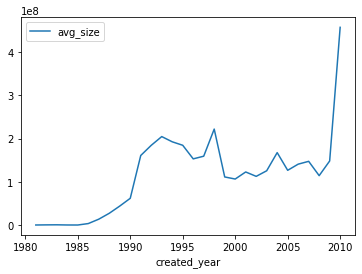

In [18]:
wb_df['start_date'] = pd.to_datetime(wb_df.start_date)
wb_df['created_year'] = wb_df.start_date.dt.year
wb_df[wb_df['created_year'] > 1980].groupby('created_year').agg(avg_size=('wb_lendingproject_cost', 'mean')).plot.line()

So use:

* GDP at current USD, from WDI
* Multiply by % of GDP
* Compare to WB loan size

In [19]:
relevant_codes = {
    'GDP_current_USD': 'NY.GDP.MKTP.CD',
    'GovtExpenses_current_USD': 'GC.XPN.TOTL.GD.ZS'
}

wb_extract = extract_indicators(wdi_df, relevant_codes.values())

expense_df = wb_extract[wb_extract['Indicator Code'] == 'GC.XPN.TOTL.GD.ZS']

<AxesSubplot:xlabel='year'>

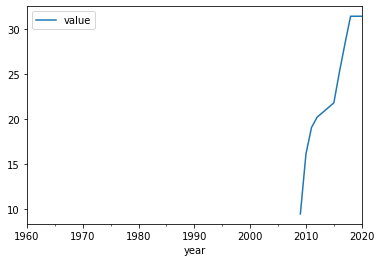

In [20]:
country_code = 'ZWE' # use Zim as an example
country_exp_row = expense_df[expense_df['Country Code'] == country_code]

edf = country_exp_row.drop(columns=['Indicator Name', 'Indicator Code', 'Unnamed: 65'], errors='ignore').melt(id_vars=['Country Code', 'Country Name'])
edf = edf.rename(columns = { 'variable': 'year' })

edf['year'] = pd.to_datetime(edf['year'])

edf = edf.set_index('year')
edf = edf.interpolate()
edf.plot.line()

### Checking indicator coverage on budget, etc

Ratio not available:  0.7019906323185011


<AxesSubplot:>

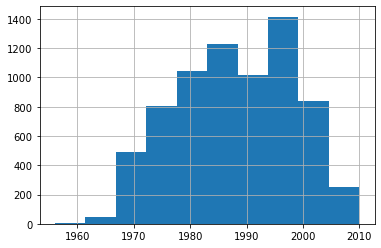

In [21]:
edf2 = expense_df.drop(columns=['Indicator Name', 'Indicator Code', 'Unnamed: 65'], errors='ignore').melt(id_vars=['Country Code', 'Country Name'])
edf2 = edf2[edf2['Country Code'].isin(wb_df.country_code)]

print("Ratio not available: ",  edf2.value.isna().sum() / len(edf2))

wb_df.created_year.hist()

In [24]:
print(calculate_ratio_na(wdi_df, 'GC.XPN.TOTL.GD.ZS', wb_df.country_code))
print(calculate_ratio_na(wdi_df, 'DT.ODA.ODAT.GN.ZS', wb_df.country_code))

0.6364285714285715
0.2810714285714286


In [25]:
# Expense. GC.XPN.TOTL.CN (or GC.XPN.TOTL.ZS) for total expenses. But only current LCU.
# Tax revenue. GC.TAX.TOTL.CN (or GC.TAX.TOTL.GD.ZS) for total revenue. Also only current LCU

In [26]:
candidate_vars = [
    'NY.GDP.MKTP.CD',
    'GC.XPN.TOTL.GD.ZS',
    'GC.XPN.TOTL.ZS',
    'GC.TAX.TOTL.CN',
    'GC.TAX.TOTL.GD.ZS',
    'IQ.CPA.FINQ.XQ',
    'SE.XPD.TOTL.GD.ZS',
    'GB.XPD.RSDV.GD.ZS',
    'DT.ODA.ODAT.GN.ZS'
]

In [28]:
na_ratios = [calculate_ratio_na(wdi_df, code, wb_df.country_code) for code in candidate_vars]
print(dict(zip(candidate_vars, na_ratios)))

{'NY.GDP.MKTP.CD': 0.16142857142857142, 'GC.XPN.TOTL.GD.ZS': 0.6364285714285715, 'GC.XPN.TOTL.ZS': nan, 'GC.TAX.TOTL.CN': 0.6139285714285714, 'GC.TAX.TOTL.GD.ZS': 0.6210714285714286, 'IQ.CPA.FINQ.XQ': 0.8692857142857143, 'SE.XPD.TOTL.GD.ZS': 0.6039285714285715, 'GB.XPD.RSDV.GD.ZS': 0.7767857142857143, 'DT.ODA.ODAT.GN.ZS': 0.2810714285714286}


/home/luke/newproj/wbwdi/src/futil.py:77: RuntimeWarning: invalid value encountered in long_scalars
  return tdf.value.isna().sum() / len(tdf)


### Result: at present, looks like we have to use just GDP in current USD.

**Note**: Weirdly, have more data points for education share of expenditure

## Checking feasibility of windows with no active project

In [29]:
project_df.crs_purpose_sector.value_counts()

311.0    1608
210.0    1466
230.0    1026
140.0     914
151.0     736
240.0     598
321.0     571
430.0     562
122.0     539
600.0     535
130.0     412
160.0     361
112.0     252
220.0     235
113.0     232
121.0     209
510.0     204
322.0     187
312.0     177
114.0     144
410.0     142
720.0     130
111.0     124
250.0     109
313.0      81
110.0      66
120.0      61
730.0      57
331.0      55
152.0      40
530.0      39
332.0      23
310.0      17
520.0      13
740.0      11
998.0       8
700.0       8
323.0       2
930.0       1
920.0       1
320.0       1
420.0       1
Name: crs_purpose_sector, dtype: int64

<AxesSubplot:>

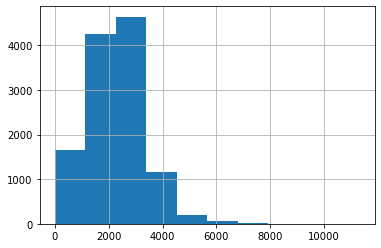

In [30]:
project_df.project_duration.hist()

In [31]:
project_df.mmg_purpose_sectorname.value_counts()

Road transport                                                  945
Debt forgiveness                                                529
Water supply and sanitation - large systems                     511
Public sector policy and administrative management              473
Agricultural development                                        405
                                                               ... 
Trade education/training                                          1
Personnel development for population and reproductive health      1
Refugees in donor countries                                       1
MINERAL RESOURCES AND MINING                                      1
Storage                                                           1
Name: mmg_purpose_sectorname, Length: 211, dtype: int64

In [32]:
project_df.mmg_purpose_sector.value_counts()

21020    945
60020    529
14020    511
15110    473
31140    405
        ... 
21061      1
24005      1
23066      1
31282      1
15261      1
Name: mmg_purpose_sector, Length: 214, dtype: int64

In [33]:
project_df.aiddata_sectorname.value_counts()

Agriculture                                                                       1169
TRANSPORT AND STORAGE                                                              799
Multisector                                                                        542
ENERGY GENERATION AND SUPPLY                                                       541
Government and civil society, general                                              459
Basic health                                                                       401
Industry                                                                           389
WATER SUPPLY AND SANITATION                                                        368
GENERAL BUDGET SUPPORT                                                             324
POPULATION POLICIES/ PROGRAMMES AND REPRODUCTIVE HEALTH                            306
OTHER SOCIAL INFRASTRUCTURE AND SERVICES                                           237
Mineral resources and mining               

In [34]:
project_df['start_dt'] = pd.to_datetime(project_df['start_date'], format='%d%b%Y', errors='coerce')

In [39]:
sector_mapping_table = pd.read_csv('../data/sector_mapping.csv')

In [40]:
sector_mapping_table.head()

,mmg_purpose_sector,mmg_purpose_sectorname,mmg_purpose_code,mmg_purpose_codename,sector
0,11000,Education,110,EDUCATION,Education
1,11100,Education,111,"Education, level unspecified -",Education
2,11105,Education,111,"Education, level unspecified -",Education
3,11110,Education policy and administrative management,111,"Education, level unspecified -",Education
4,11120,Education facilities and training,111,"Education, level unspecified -",Education


In [42]:
project_df = project_df.merge(
    sector_mapping_table[['mmg_purpose_sector', 'sector']], 
    left_on='mmg_purpose_sector', 
    right_on='mmg_purpose_sector',
    how='left'
)

In [190]:
sector_aggs = project_df.groupby('sector').agg(
    number_projects=('ppd_project_id', 'nunique'),
    earliest_year=('start_dt', 'min'),
    latest_project=('start_dt', 'max'),
    number_donors=('donor_name', 'nunique'),
    avg_rating=('six_overall_rating', 'mean'),
    avg_duration=('project_duration', 'mean')
)

In [191]:
sector_aggs

,number_projects,earliest_year,latest_project,number_donors,avg_rating,avg_duration
sector,,,,,,
Agriculture,2139,1961-01-01,2010-04-01,7,3.945315,2688.239551
Debt,536,1963-01-01,2003-01-01,4,3.932458,2299.308851
Education,964,1964-01-01,2009-10-09,6,4.345599,2417.854041
Energy,1180,1960-01-01,2008-07-02,6,4.363322,2587.785095
Environment,311,1974-01-01,2010-03-16,7,4.354027,2601.019531
Finance,662,1968-01-01,2010-01-01,7,4.130533,1993.956098
Governance,1132,1969-01-01,2010-12-01,7,4.209571,1756.464342
Health,1482,1970-01-01,2012-01-01,8,4.507777,1959.853617
Housing,87,1977-01-01,2008-01-01,4,4.202469,2399.043478


### Finding year-gaps, for treatment

In [65]:
time_cols = [
    'country_code', 
    'donor_name', 
    'aiddata_sectorname', 
    'six_overall_rating', 
    'start_date', 
    'completion_date', 
    'project_duration',
    'sector'
]

In [66]:
pdf = narrow_convert_project_data(project_df, time_cols)

<AxesSubplot:>

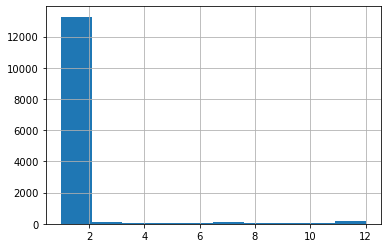

In [67]:
pdf.completion_dt.dt.month.hist()

### NB reasoning on years

1. Vast majority of projects have completion date as 1 January. Suggesting specific completion dates are generally not recorded, i.e., assume some normal distribution throughout year.
2. On the other hand, by project completion most activities should have been underway for some time. So it is plausible to consider the year of the project as year 1 for lags. If a project has completion date 2010, outcome effects on a lag of 5 years would be evaluated in 2014.
3. That also implies a no-treatment year is any in which no project is active and is not within the lag period of a completed project.

In [53]:
example_year = datetime(2000, 1, 1)
len(pdf[pdf.start_dt > example_year])

2428

In [54]:
len(pdf)

13971

<AxesSubplot:>

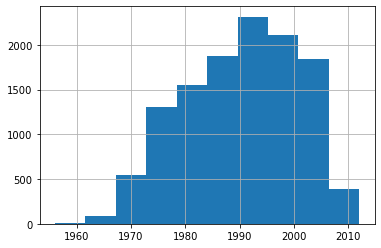

In [56]:
pdf.start_year.hist()

In [57]:
active_projects = pdf[(pdf.start_dt < example_year) & (pdf.completion_dt > example_year)]

In [58]:
active_projects.head()

,country_code,donor_name,aiddata_sectorname,six_overall_rating,start_date,completion_date,project_duration,start_dt,start_year,completion_dt,end_year
0,CHN,AsianDB,NaN,4.5,26nov1996,01jan2003,2555.0,1996-11-26,1996.0,2003-01-01,2003.0
7,NEP,AsianDB,NaN,4.5,21sep1995,01jan2003,2920.0,1995-09-21,1995.0,2003-01-01,2003.0
12,PHI,AsianDB,NaN,4.5,18dec1998,01jan2009,4015.0,1998-12-18,1998.0,2009-01-01,2009.0
29,THI,AsianDB,NaN,3.0,23sep1999,01jan2003,1460.0,1999-09-23,1999.0,2003-01-01,2003.0
39,CAM,AsianDB,NaN,4.5,20jun1996,01jan2001,1825.0,1996-06-20,1996.0,2001-01-01,2001.0


In [59]:
len(active_projects)

2532

In [60]:
example_lag_years = 5

In [61]:
active_projects = pdf[(pdf.start_dt < example_year) & ((pdf.completion_dt + timedelta(days=(5*365))) > example_year)]

In [62]:
len(active_projects)

4440

In [82]:
total_countries = pdf.country_code.nunique()
earliest_year = pdf.start_year.min()
latest_year = pdf.start_year.max()

In [83]:
total_countries

176

In [73]:
year_range = range(int(earliest_year), int(latest_year))

In [74]:
pdf.sector.value_counts()

Agriculture     2103
Transport       1632
Health          1479
Other           1424
Energy          1175
Governance      1130
Wash            1002
Education        958
Industry         681
Debt             534
Humanitarian     490
Finance          444
Environment      308
Telecom          256
Mineral          205
Housing           81
Trade             69
Name: sector, dtype: int64

In [101]:
def count_countries_in_window(year_lag=5, in_sector=None):
    countries_with_active_projects = []
    for year in year_range:
        ref_year = datetime(year, 1, 1)
        
        active_mask = pdf.start_dt < ref_year
        lag_mask = (pdf.completion_dt + timedelta(days=(5*365))) > ref_year
        active_plus_lag_mask = active_mask & lag_mask
        sector_mask = pdf.sector == in_sector
        
        final_mask = (active_plus_lag_mask & sector_mask) if in_sector is not None else active_plus_lag_mask
        
        countries_with_active_projects.append(pdf[final_mask].country_code.nunique())
    
    prop_countries_untreated = [1 - count / total_countries for count in countries_with_active_projects]
    return prop_countries_untreated

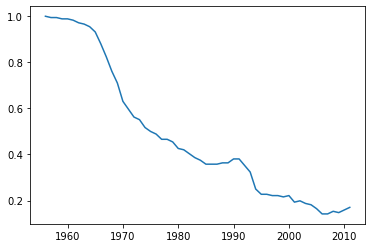

In [102]:
fig, ax = plt.subplots()
ax.plot(year_range, count_countries_in_window(year_lag=0))

(0.0, 1.0)

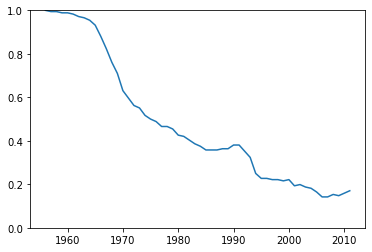

In [103]:
fig, ax = plt.subplots()
ax.plot(year_range, count_countries_in_window())
ax.set_ylim([0, 1])

(0.0, 1.0)

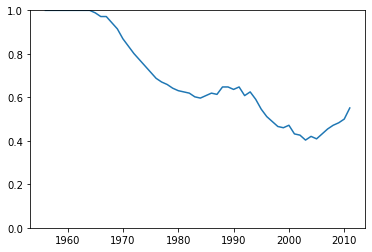

In [104]:
fig, ax = plt.subplots()
ax.plot(year_range, count_countries_in_window(year_lag=5, in_sector='Education'))
ax.set_ylim([0, 1])

** In other words: can only get to binary using sectors

In [105]:
assemble_sector_dict = lambda sector: dict(zip(year_range, count_countries_in_window(year_lag=5, in_sector=sector)))
# mean_sector_treat = lambda sector: 

In [118]:
def calc_sector_post_year_gaps(sector, year):
    sector_post_year = [value for key, value in assemble_sector_dict(sector).items() if key >= year]
    mean_post_year = sum(sector_post_year) / len(sector_post_year)
    return mean_post_year

In [119]:
calc_sector_post_year_gaps('Education', 1990)

0.5015495867768593

In [192]:
sector_aggs = sector_aggs.reset_index()

In [193]:
sector_aggs['mean_gap'] = sector_aggs['sector'].apply(lambda sector: calc_sector_post_year_gaps(sector, 1990))

In [194]:
sector_aggs.sort_values(['mean_gap', 'number_projects'], ascending=False)

,sector,number_projects,earliest_year,latest_project,number_donors,avg_rating,avg_duration,mean_gap
14,Trade,69,1980-12-06,2008-01-01,5,4.436765,1220.812500,0.938533
8,Housing,87,1977-01-01,2008-01-01,4,4.202469,2399.043478,0.891012
9,Humanitarian,496,1975-04-11,2009-01-01,6,4.808554,1644.445455,0.859762
1,Debt,536,1963-01-01,2003-01-01,4,3.932458,2299.308851,0.857438
11,Mineral,206,1964-01-01,2005-01-01,5,4.178537,2166.837438,0.844783
13,Telecom,256,1967-01-01,2006-06-01,5,4.725397,2315.410359,0.787707
4,Environment,311,1974-01-01,2010-03-16,7,4.354027,2601.019531,0.747934
10,Industry,695,1962-01-01,2008-06-05,7,3.945627,2291.059200,0.686209
5,Finance,662,1968-01-01,2010-01-01,7,4.130533,1993.956098,0.652118
6,Governance,1132,1969-01-01,2010-12-01,7,4.209571,1756.464342,0.556818


In [195]:
project_df.donor_name.value_counts()

WB         7146
KfW        2229
DFID       1917
AsianDB    1572
JICA        723
GFATM       581
GiZ         129
IFAD         55
Name: donor_name, dtype: int64

In [196]:
post_1990_wb_proj_mask = (project_df.start_dt.dt.year > 1990) & (project_df.donor_name == 'WB') 
post_1990_wb_proj_count = project_df[post_1990_wb_proj_mask].groupby('sector', as_index=False).agg(
    wb_1990_proj_count=('ppd_project_id', 'nunique'),
    wb_1990_rating_mean=('six_overall_rating', 'mean'),
    wb_1990_rating_dev=('six_overall_rating', 'std'),
    wb_loan_amount=('wb_lendingproject_cost', 'sum')
)

In [197]:
post_1990_wb_proj_count

,sector,wb_1990_proj_count,wb_1990_rating_mean,wb_1990_rating_dev,wb_loan_amount
0,Agriculture,300,4.064846,1.143427,3.355578e+10
1,Debt,134,4.029851,1.291617,8.778601e+09
2,Education,287,4.188612,1.012429,4.145720e+10
3,Energy,201,4.113990,1.248942,7.666548e+10
4,Environment,133,4.269231,0.938318,7.041919e+09
5,Finance,173,4.205882,1.166074,2.520311e+10
6,Governance,394,4.072165,1.120607,3.560972e+10
7,Health,248,4.028689,1.134566,2.699627e+10
8,Housing,20,4.000000,1.028992,6.003468e+09
9,Humanitarian,30,4.166667,1.176885,6.459889e+09


In [198]:
sector_aggs = sector_aggs.merge(post_1990_wb_proj_count, how='left', on='sector')

In [199]:
sector_aggs['wb_loan_amount'] = sector_aggs['wb_loan_amount'] / 1e9

In [200]:
sector_aggs.sort_values(['wb_1990_proj_count', 'mean_gap'], ascending=False)

,sector,number_projects,earliest_year,latest_project,number_donors,avg_rating,avg_duration,mean_gap,wb_1990_proj_count,wb_1990_rating_mean,wb_1990_rating_dev,wb_loan_amount
12,Other,1484,1963-10-07,2010-01-01,7,4.185764,2022.001643,0.488120,526,4.239216,1.130759,88.576101
6,Governance,1132,1969-01-01,2010-12-01,7,4.209571,1756.464342,0.556818,394,4.072165,1.120607,35.609716
0,Agriculture,2139,1961-01-01,2010-04-01,7,3.945315,2688.239551,0.475723,300,4.064846,1.143427,33.555783
2,Education,964,1964-01-01,2009-10-09,6,4.345599,2417.854041,0.501550,287,4.188612,1.012429,41.457200
15,Transport,1643,1956-01-01,2008-03-17,5,4.385547,2549.416404,0.469267,267,4.494297,0.956579,71.216821
7,Health,1482,1970-01-01,2012-01-01,8,4.507777,1959.853617,0.489153,248,4.028689,1.134566,26.996274
3,Energy,1180,1960-01-01,2008-07-02,6,4.363322,2587.785095,0.542355,201,4.113990,1.248942,76.665484
16,Wash,1009,1964-01-01,2008-09-12,7,4.115170,2793.927521,0.470558,190,4.058201,1.203629,29.771444
5,Finance,662,1968-01-01,2010-01-01,7,4.130533,1993.956098,0.652118,173,4.205882,1.166074,25.203108
1,Debt,536,1963-01-01,2003-01-01,4,3.932458,2299.308851,0.857438,134,4.029851,1.291617,8.778601


<AxesSubplot:xlabel='mean_gap', ylabel='wb_1990_proj_count'>

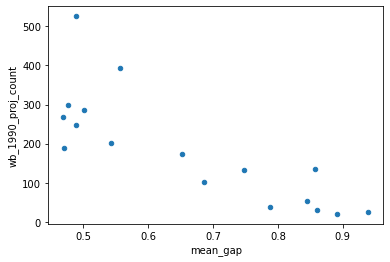

In [201]:
sector_aggs.plot.scatter(x='mean_gap', y='wb_1990_proj_count')

In [202]:
sector_aggs.sort_values(['wb_1990_proj_count', 'mean_gap'], ascending=False).to_csv(
    '../data/sector_project_gap_counts.csv', index=False, float_format='%.2f'
)

## Now checking indicator coverage

In [158]:
sector_indicators = pd.read_csv('../data/sector_mapping_indicators.csv')

In [159]:
sector_indicators

,indicator name,indicator code,sector
0,"Adjusted net enrollment rate, primary (% of pr...",SE.PRM.TENR,Education
1,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,Health
2,"Energy use (kg of oil equivalent) per $1,000 G...",EG.USE.COMM.GD.PP.KD,Energy
3,"Immunization, measles (% of children ages 12-2...",SH.IMM.MEAS,Health
4,Improved sanitation facilities (% of populatio...,SH.STA.ACSN,Wash
5,Improved water source (% of population with ac...,SH.H2O.SAFE.ZS,Wash
6,"Incidence of tuberculosis (per 100,000 people)",SH.TBS.INCD,Health
7,Internet users (per 100 people),IT.NET.USER.P2,Telecom
8,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,Education
9,Mobile cellular subscriptions (per 100 people),IT.CEL.SETS.P2,Telecom


In [160]:
sector_indicators['ratio_available'] = sector_indicators['indicator code'].apply(
    lambda code: calculate_ratio_na(wdi_df, code, wb_df.country_code, earliest_year=1990)
)

In [164]:
sector_indicators.sort_values('sector').to_csv('../data/sector_codes_with_coverage.csv', index=False, float_format = '%.2f')